In [49]:
import pandas as pd
import os
import chardet
import unicodedata

from sklearn.neighbors import NearestCentroid

import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
data_folder = "../storage/raw"
data_file = "may_meteo21.csv"
general_weather_file = "Estaciones_control_datos_meteorologicos.csv"
#general_bike_stations_file = "bases_bicimad_mod.csv"
bike_stations = "202105_merged_trips_stations.csv"

In [51]:
def basic_df_load_and_clean(data_folder, data_file_name):
    #this 2 lines allow to retrieve the encoding so that we can open the file
    with open(os.path.join(data_folder, data_file_name), 'rb') as f:
        result = chardet.detect(f.read())

    df = pd.read_csv(os.path.join(data_folder, data_file_name), sep=";",encoding=result['encoding'])

    # define a helper function to remove accents from text
    def remove_accents(text):
        return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

    #setting all column names into lowercase without accents
    # get the current column names
    old_column_names = df.columns.tolist()

    # remove accents and set to lowercase for each column name
    new_column_names = [remove_accents(name).lower() for name in old_column_names]

    # use the new column names to rename the columns
    df = df.rename(columns=dict(zip(old_column_names, new_column_names)))

    df = df.dropna(how="all")

    return df

def parse_hour(input):
    if "HO" in input:
        out = input.replace("HO","")
    if "H" in input:
        out = input.replace("H","")
    out = int(out)
    if out == 24:
        out = 0
    return out

# Finding merging mechanism

## Loading data

In [52]:
ws_df = basic_df_load_and_clean(data_folder, general_weather_file)
#bs_df = basic_df_load_and_clean(data_folder, general_bike_stations_file)
hist_stations_df = pd.read_csv(os.path.join(data_folder,"202105_merged_trips_stations.csv"))
weather_df = pd.read_csv(os.path.join(data_folder, data_file), sep=";")

From historical bike stations information we will want a subset of the dataframe with only 1 row per station, and only the columns id, longitude and magnitude so that we can relate bike stations with weather stations

In [53]:

bs_df = hist_stations_df.groupby("id_station").first().reset_index()[["id_station", "longitude", "latitude"]]
bs_df.columns = ["id_station", "longitud", "latitud"]
bs_df

,id_station,longitud,latitud
0,1,-3.701834,40.417214
1,2,-3.701603,40.417313
2,3,-3.705842,40.420589
3,4,-3.706917,40.430294
4,5,-3.702587,40.428552
...,...,...,...
259,266,-3.726990,40.443750
260,267,-3.726930,40.443420
261,268,-3.727310,40.449120
262,269,-3.729370,40.451090


In [54]:
ws_df.head()

,codigo,codigo_corto,estacion,direccion,longitud_etrs89,latitud_etrs89,altitud,vv (81),dv (82),t (83),...,cod_via,via_clase,via_par,via_nombre,num_via,coordenada_x_etrs89,coordenada_y_etrs89,longitud,latitud,unnamed: 23
0,28079004.0,4.0,Plaza España,Plaza de España,"3°42'43.91""O","40°25'25.98""N",637.0,NaN,NaN,X,...,273600.0,PLAZA,DE,ESPAÑA,NaN,"439579,3291","4475049,263",-3.712257,40.423882,NaN
1,28079008.0,8.0,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,"3°40'56.22""O","40°25'17.63""N",672.0,NaN,NaN,X,...,18900.0,CALLE,DE,ALCALA,NaN,"442117,2366","4474770,696",-3.682316,40.421553,NaN
2,28079016.0,16.0,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,"3°38'21.17""O","40°26'24.20""N",695.0,NaN,NaN,X,...,798700.0,CALLE,DEL,VIZCONDE DE LOS ASILOS,NaN,"445786,1729","4476796,019",-3.639242,40.440046,NaN
3,28079018.0,18.0,Farolillo,Calle Farolillo - C/Ervigio,"3°43'54.61""O","40°23'41.22""N",632.0,NaN,NaN,X,...,1903.0,CALLE,DEL,FAROLILLO,NaN,"437891,6961","4471832,769",-3.731836,40.394782,NaN
4,28079024.0,24.0,Casa de Campo,Casa de Campo (Terminal del Teleférico),"3°44'50.44""O","40°25'9.69""N",646.0,X,X,X,...,905219.0,CARRETERA,DEL,TELEFERICO,NaN,"436598,5637","4474571,618",-3.747345,40.419358,NaN


In [55]:
ws_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   codigo               26 non-null     float64
 1   codigo_corto         26 non-null     float64
 2   estacion             26 non-null     object 
 3   direccion            26 non-null     object 
 4   longitud_etrs89      26 non-null     object 
 5   latitud_etrs89       26 non-null     object 
 6   altitud              26 non-null     float64
 7   vv (81)              10 non-null     object 
 8   dv (82)              10 non-null     object 
 9   t (83)               25 non-null     object 
 10  hr (86)              23 non-null     object 
 11  pb (87)              8 non-null      object 
 12  rs (88)              8 non-null      object 
 13  p (89)               10 non-null     object 
 14  cod_via              25 non-null     float64
 15  via_clase            26 non-null     objec

The nulls in each magnitude mark the stations that **do not** register that magnitude

In [56]:
bs_df.head()

,id_station,longitud,latitud
0,1,-3.701834,40.417214
1,2,-3.701603,40.417313
2,3,-3.705842,40.420589
3,4,-3.706917,40.430294
4,5,-3.702587,40.428552


In [57]:
bs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_station  264 non-null    int64  
 1   longitud    264 non-null    float64
 2   latitud     264 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 6.3 KB


## Fixing problems in the general list of weather stations

### Some stations, for some magnitudes, did not have the whole month of data

This is a problem, because as we are dealing with time series, we need the data to be continuous. We cannot miss a day. From the analysis we have seen that it is a whole station which presents this problem. It makes sense, as it would be very strange for a station to register some magnitudes and not others in one period of time. To solve for this, we will delete the registers of the stations that don't account for the maximum number of days registering data on that month. We need to set it like that because each month has 30, 31 or 27 days. Then, as we have a lot of weather stations, we will assign the bike stations close to the deleted weather station to another weather station

Thankfully this problem cannot happen in the hours time range, as a day data point contains the 24 hours.

In [58]:
counting_analysis = weather_df[["ESTACION", "MAGNITUD", "DIA"]].groupby(["ESTACION", "MAGNITUD"]).count().reset_index()
counting_analysis

,ESTACION,MAGNITUD,DIA
0,4,83,31
1,8,83,31
2,8,86,31
3,16,86,31
4,18,83,31
...,...,...,...
85,112,86,31
86,113,83,31
87,113,86,31
88,115,83,31


In [59]:
counting_analysis["DIA"].unique()

array([31, 30])

In [60]:
counting_analysis[counting_analysis["DIA"] == 30]

,ESTACION,MAGNITUD,DIA
71,108,81,30
72,108,82,30
73,108,83,30
74,108,86,30
75,108,87,30
76,108,88,30
77,108,89,30


In [61]:
days_of_month = counting_analysis["DIA"].unique().max()
days_of_month

31

In [62]:
stations_to_delete = counting_analysis.loc[counting_analysis["DIA"]<days_of_month, "ESTACION"].unique()
stations_to_delete

array([108])

In [63]:
weather_df_filtered = weather_df[~weather_df["ESTACION"].isin(stations_to_delete)]

In [64]:
# checking that station 108 is not there
weather_df_filtered["ESTACION"].unique()

array([102, 103, 104, 106, 107, 109, 110, 111, 112, 113, 115,   4,   8,
        16,  18,  24,  35,  36,  38,  39,  54,  56,  58,  59])

### Incoherences between weather stations register and weather stations gathering data

There is a small problem. For example for march 2021 (currently being analyzed), there are stations that are registered in ws_df BUT are not gathering data, so they don't appear in weather_df (historical data). I imagine this is caused due to errors or maintenance. We will assume this is caused for reasons such as maintenance, and that there is a possibility of some stations not existing in the historical dataframe in different moments of time, and that the ws_df contains ALL weather stations. This will force us to first filter the weather stations through the stations gathering data in the weather historical data.

In [65]:
ws_df["codigo_corto"].sort_values().unique()

array([  4.,   8.,  16.,  18.,  24.,  35.,  36.,  38.,  39.,  54.,  56.,
        58.,  59., 102., 103., 104., 106., 107., 108., 109., 110., 111.,
       112., 113., 114., 115.])

In [66]:
weather_df["ESTACION"].sort_values().unique()

array([  4,   8,  16,  18,  24,  35,  36,  38,  39,  54,  56,  58,  59,
       102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 115])

In [67]:
# we ensure we are only working with the stations that are gathering data at any time
ws_df_filtered = ws_df[ws_df["codigo_corto"].isin(weather_df_filtered["ESTACION"].unique())]

Weather station 114 exists in the general table but is not gathering data at least for this month

### The weather stations file IS NOT CORRECT FOR THE MAGNITUDES EACH STATION MEASURES

For example, for station 16 the csv states that it is measuring magnitudes 83 and 86, but then only magnitude 86 is registered for march of 2021. Again, we don't know the reason for this misconfiguration, so we will make the code robust adjusting the magnitudes stated in the ws_df to those seen in the historical dataframe.

In [68]:
"""
81 - VELOCIDAD VIENTO
82 - DIR. DE VIENTO
83 - TEMPERATURA
86 - HUMEDAD RELATIVA
87 - PRESION BARIOMETRICA
88 - RADIACION SOLAR
89 - PRECIPITACIÓN"""
#we rename the columns
MAGNITUDES = ["vv (81)", "dv (82)", "t (83)", "hr (86)", "pb (87)", "rs (88)", "p (89)"]
ws_df_filtered = ws_df_filtered.rename(dict(zip(MAGNITUDES, [81, 82, 83, 86, 87, 88, 89])), axis=1)
ws_df_filtered["codigo_corto"] = ws_df_filtered["codigo_corto"].astype(int)
MAGNITUDES = [81, 82, 83, 86, 87, 88, 89]

In [69]:
# magnitudes values for station 16
ws_df_filtered.loc[ws_df_filtered["codigo_corto"]==16, MAGNITUDES]

,81,82,83,86,87,88,89
2,NaN,NaN,X,X,NaN,NaN,NaN


In [70]:
for magnitud in MAGNITUDES:
    stations_per_magnitude = weather_df_filtered.loc[weather_df_filtered["MAGNITUD"] == magnitud, "ESTACION"].unique()
    ws_df_filtered.loc[~ws_df_filtered["codigo_corto"].isin(stations_per_magnitude), magnitud] = None

In [71]:
ws_df_filtered.head()

,codigo,codigo_corto,estacion,direccion,longitud_etrs89,latitud_etrs89,altitud,81,82,83,...,cod_via,via_clase,via_par,via_nombre,num_via,coordenada_x_etrs89,coordenada_y_etrs89,longitud,latitud,unnamed: 23
0,28079004.0,4,Plaza España,Plaza de España,"3°42'43.91""O","40°25'25.98""N",637.0,None,None,X,...,273600.0,PLAZA,DE,ESPAÑA,NaN,"439579,3291","4475049,263",-3.712257,40.423882,NaN
1,28079008.0,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,"3°40'56.22""O","40°25'17.63""N",672.0,None,None,X,...,18900.0,CALLE,DE,ALCALA,NaN,"442117,2366","4474770,696",-3.682316,40.421553,NaN
2,28079016.0,16,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,"3°38'21.17""O","40°26'24.20""N",695.0,None,None,None,...,798700.0,CALLE,DEL,VIZCONDE DE LOS ASILOS,NaN,"445786,1729","4476796,019",-3.639242,40.440046,NaN
3,28079018.0,18,Farolillo,Calle Farolillo - C/Ervigio,"3°43'54.61""O","40°23'41.22""N",632.0,None,None,X,...,1903.0,CALLE,DEL,FAROLILLO,NaN,"437891,6961","4471832,769",-3.731836,40.394782,NaN
4,28079024.0,24,Casa de Campo,Casa de Campo (Terminal del Teleférico),"3°44'50.44""O","40°25'9.69""N",646.0,X,X,X,...,905219.0,CARRETERA,DEL,TELEFERICO,NaN,"436598,5637","4474571,618",-3.747345,40.419358,NaN


In [72]:
# magnitudes values for station 16
ws_df_filtered.loc[ws_df_filtered["codigo_corto"]==16, MAGNITUDES]

,81,82,83,86,87,88,89
2,None,None,None,X,None,None,None


## WARNING:

having done all these adjustments and assuming that there can be variations between months in magnitudes registered or working stations, this code must be executed month by month (if we assume everything is constant and nice during the whole month). Maybe it can be executed for a whole dataframe with all the months, but I am not sure.

## Merging mechanism

To merge bike stations and weather stations we are going to use the location. We are going to assign the closest weather station to each bike station, so that weather data is as accurate as possible. We are going to use NearestCentroid, which bassically assigns the closest class to each data point. As this classification is a spatial classification taking into account longitude and latitude, it will be more than enough

IMPORTANT! I have seen that not all stations measure all magnitudes. So the ideal case scenario is to build a merging mechanism for each magnitude, so that each bike station looks for the data of each magnitude in the nearest weather station that measures that magnitude.

### Merging mechanism per each magnitude

In [73]:
"""
81 - VELOCIDAD VIENTO
82 - DIR. DE VIENTO
83 - TEMPERATURA
86 - HUMEDAD RELATIVA
87 - PRESION BARIOMETRICA
88 - RADIACION SOLAR
89 - PRECIPITACIÓN"""

ws_df_filtered.head()

,codigo,codigo_corto,estacion,direccion,longitud_etrs89,latitud_etrs89,altitud,81,82,83,...,cod_via,via_clase,via_par,via_nombre,num_via,coordenada_x_etrs89,coordenada_y_etrs89,longitud,latitud,unnamed: 23
0,28079004.0,4,Plaza España,Plaza de España,"3°42'43.91""O","40°25'25.98""N",637.0,None,None,X,...,273600.0,PLAZA,DE,ESPAÑA,NaN,"439579,3291","4475049,263",-3.712257,40.423882,NaN
1,28079008.0,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,"3°40'56.22""O","40°25'17.63""N",672.0,None,None,X,...,18900.0,CALLE,DE,ALCALA,NaN,"442117,2366","4474770,696",-3.682316,40.421553,NaN
2,28079016.0,16,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,"3°38'21.17""O","40°26'24.20""N",695.0,None,None,None,...,798700.0,CALLE,DEL,VIZCONDE DE LOS ASILOS,NaN,"445786,1729","4476796,019",-3.639242,40.440046,NaN
3,28079018.0,18,Farolillo,Calle Farolillo - C/Ervigio,"3°43'54.61""O","40°23'41.22""N",632.0,None,None,X,...,1903.0,CALLE,DEL,FAROLILLO,NaN,"437891,6961","4471832,769",-3.731836,40.394782,NaN
4,28079024.0,24,Casa de Campo,Casa de Campo (Terminal del Teleférico),"3°44'50.44""O","40°25'9.69""N",646.0,X,X,X,...,905219.0,CARRETERA,DEL,TELEFERICO,NaN,"436598,5637","4474571,618",-3.747345,40.419358,NaN


### Assigning weather station to bike stations for each magnitude

In [74]:
# adding for each magnitude the nearest weather station to each bike station

coord_bs = bs_df[["latitud", "longitud"]]

classifier = NearestCentroid()

for magnitude in MAGNITUDES:
    #we select the rows of the stations that measure each magnitude
    ws_df_magnitude = ws_df_filtered[~ws_df_filtered[magnitude].isna()]
    #we get the coordinates of the stations that measure that specific magnitude
    coord_ws_magnitude = ws_df_magnitude[["latitud","longitud"]]
    stations_magnitude = ws_df_magnitude["codigo_corto"]
    # we fit the model with the stations of this magnitude
    classifier.fit(coord_ws_magnitude, stations_magnitude)
    # we assign a weather station to each bike station per each magnitude
    ws_for_bs_magnitude = classifier.predict(coord_bs)

    bs_df["weather_station_" + str(magnitude)] = ws_for_bs_magnitude

bs_df.head()

,id_station,longitud,latitud,weather_station_81,weather_station_82,weather_station_83,weather_station_86,weather_station_87,weather_station_88,weather_station_89
0,1,-3.701834,40.417214,56,56,35,35,56,24,56
1,2,-3.701603,40.417313,56,56,35,35,56,106,56
2,3,-3.705842,40.420589,56,56,35,35,56,106,56
3,4,-3.706917,40.430294,106,106,4,109,106,106,106
4,5,-3.702587,40.428552,106,106,109,109,106,106,106


now we have one weather station per magnitude assigned to each bike station so that we have the most accurate prediction of each weather magnitude possible. Also, we are taking into account only the weather stations that are gathering data.

### Visualizing weather stations

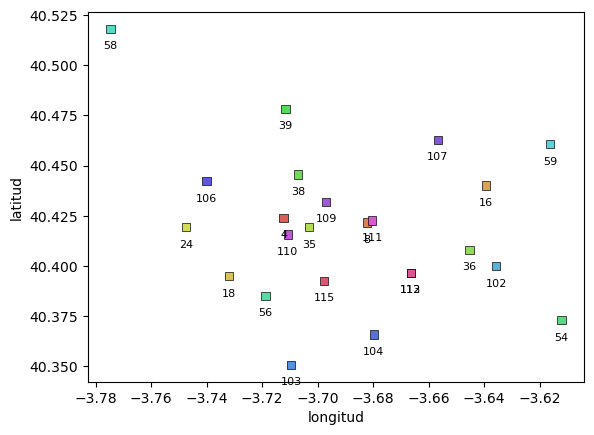

In [75]:
# palette creation with respect to the weather stations that are used for each magnitude
weather_station_codes = ws_df_filtered["codigo_corto"]
my_palette = sns.color_palette("hls", n_colors=len(list(weather_station_codes)))

# scatter plot of the weather stations
ax = sns.scatterplot(data=ws_df_filtered, x="longitud", y="latitud",hue = ws_df_filtered["codigo_corto"], palette=my_palette,
                marker="s", edgecolor="black", alpha=1, legend=None)

for i in range(ws_df_filtered.shape[0]):
        ax.text(ws_df_filtered.iloc[i]["longitud"], ws_df_filtered.iloc[i]["latitud"]-0.01, int(ws_df_filtered.iloc[i]["codigo_corto"]), ha="center", fontsize=8)

### Visualizing assignation of weather stations

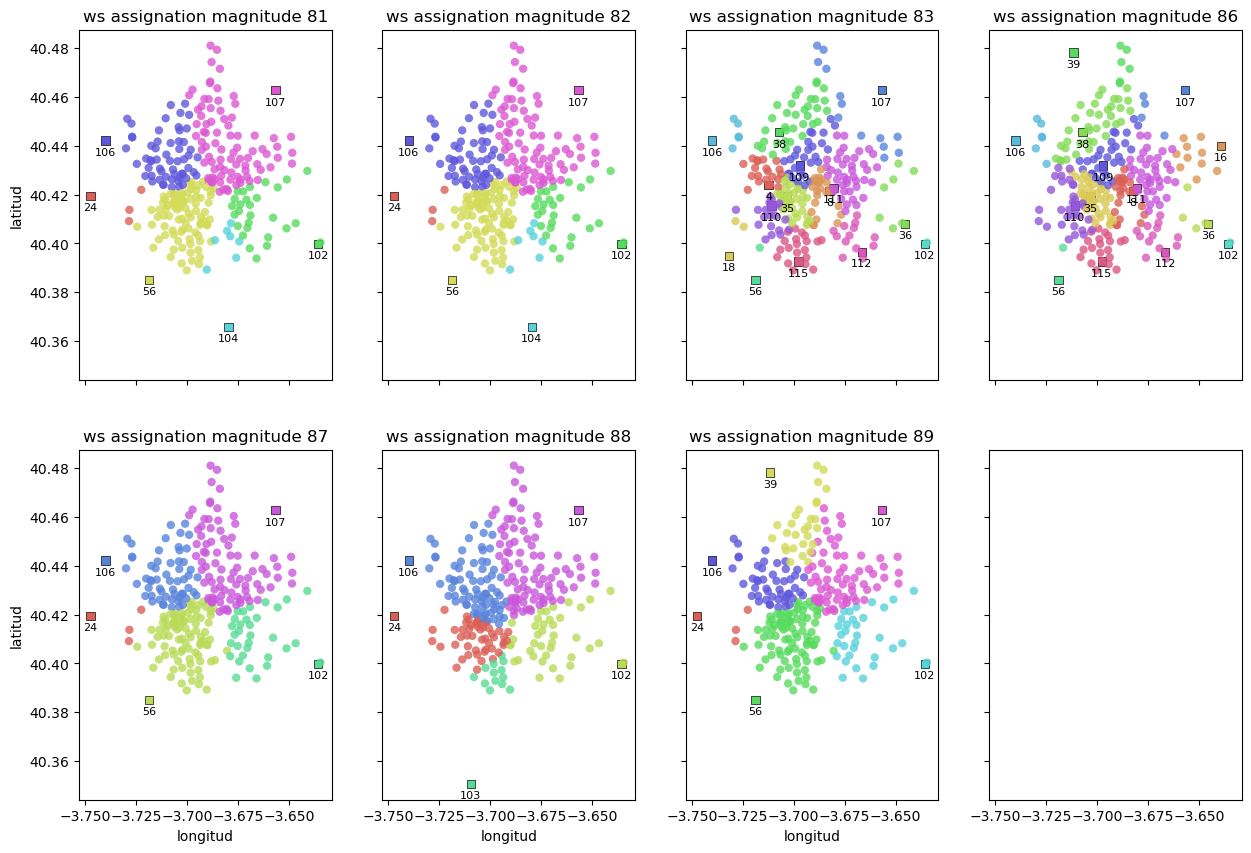

In [76]:
nrows = 2
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10),sharex=True, sharey=True)


for index, magnitude in enumerate(MAGNITUDES):
    # this is to build the rows and columns of the subplot
    if index < ncols:
        row = 0
        col = index
    else:
        row = 1
        col = index - ncols

    # palette creation with respect to the weather stations that are used for each magnitude
    weather_station_codes = bs_df["weather_station_" + str(magnitude)].unique()
    my_palette = sns.color_palette("hls", n_colors=len(list(weather_station_codes)))

    # subsample of the weather stations that register this specific magnitude
    ws_df_aux = ws_df_filtered.loc[ws_df_filtered["codigo_corto"].isin(bs_df["weather_station_" + str(magnitude)]),["longitud", "latitud", "codigo_corto"]]
    # scatter plot of the weather stations
    sns.scatterplot(data=ws_df_aux, x="longitud", y="latitud",hue = ws_df_aux["codigo_corto"], palette=my_palette,
                    marker="s", edgecolor="black", alpha=1, legend=None, ax=axes[row, col])
    
    # inserting labels to weather stations to know the code of each one
    for i in range(ws_df_aux.shape[0]):
        axes[row, col].text(ws_df_aux.iloc[i]["longitud"], ws_df_aux.iloc[i]["latitud"]-0.006, int(ws_df_aux.iloc[i]["codigo_corto"]), ha="center", fontsize=8)

    # subsample of the bike stations to get the weather station codes assigned for this magnitude
    bs_df_aux = bs_df[["longitud", "latitud", "weather_station_" + str(magnitude)]]
    # scatter plot of the bike stations
    sns.scatterplot(data=bs_df_aux, x="longitud", y="latitud",hue = bs_df_aux["weather_station_" + str(magnitude)],palette= my_palette,
                    marker="o", edgecolor="none", alpha=0.8, legend=None, ax=axes[row, col])
    
    # settint titles to the subplots
    axes[row,col].set(title="ws assignation magnitude " + str(magnitude))


This plot represents for each magnitude which is the weather station assigned to each bike station.

Weather stations are squares, bike stations circles, and all bike stations assigned to a weather station share color with the weather station.

# Processing weather data

In [77]:
weather_df_filtered.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,102,81,28079102_81_98,2021,5,1,0.97,V,...,1.67,V,1.37,V,0.93,V,0.85,V,1.10,V
1,28,79,102,81,28079102_81_98,2021,5,2,2.23,V,...,1.38,V,1.93,V,2.12,V,1.70,V,2.57,V
2,28,79,102,81,28079102_81_98,2021,5,3,2.70,V,...,3.32,V,1.27,V,2.60,V,1.92,V,2.75,V
3,28,79,102,81,28079102_81_98,2021,5,4,2.25,V,...,1.78,V,1.57,V,1.67,V,0.75,V,0.38,V
4,28,79,102,81,28079102_81_98,2021,5,5,1.00,V,...,2.05,V,1.62,V,1.57,V,1.18,V,0.68,V


In [78]:
weather_df_filtered.groupby(["ESTACION", "MAGNITUD"]).count()["DIA"].unique()

array([31])

In [79]:
melted_df = pd.melt(weather_df_filtered, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA'],
                        value_vars=['H{:02d}'.format(hour) for hour in range(1, 25)],
                        var_name='HORA', value_name='CANTIDAD')

melted_df

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,HORA,CANTIDAD
0,102,81,28079102_81_98,2021,5,1,H01,0.97
1,102,81,28079102_81_98,2021,5,2,H01,2.23
2,102,81,28079102_81_98,2021,5,3,H01,2.70
3,102,81,28079102_81_98,2021,5,4,H01,2.25
4,102,81,28079102_81_98,2021,5,5,H01,1.00
...,...,...,...,...,...,...,...,...
61747,59,89,28079059_89_98,2021,5,27,H24,0.00
61748,59,89,28079059_89_98,2021,5,28,H24,0.00
61749,59,89,28079059_89_98,2021,5,29,H24,0.00
61750,59,89,28079059_89_98,2021,5,30,H24,0.00


In [80]:
hist_weather = pd.DataFrame(columns=melted_df.columns)
hist_weather.insert(0, "id_station", None)

for magnitude in MAGNITUDES:
    bs_df_column = "weather_station_" + str(magnitude)
    # we get the assigned weather stations for each magnitude (we don't need the rest)
    magnitude_stations = bs_df[bs_df_column].sort_values().unique()
    # we filter historical weather station data with the assigned codes
    hist_weather_magnitude_stations = melted_df[melted_df["ESTACION"].isin(magnitude_stations)]
    # we filter historical weather data for only the magnitude
    hist_weather_df_magnitude = hist_weather_magnitude_stations[hist_weather_magnitude_stations["MAGNITUD"] == magnitude]
    # we subset the bike stations information df so that we only merge the current magnitude to the hist weather df
    bs_df_magnitude = bs_df[["id_station", bs_df_column]]
    
    aux = bs_df_magnitude.merge(hist_weather_df_magnitude, how = "left", right_on= ["ESTACION"], left_on=bs_df_column)
    aux = aux.drop(bs_df_column, axis = 1)
    hist_weather = pd.concat([hist_weather, aux])
    
hist_weather

,id_station,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,HORA,CANTIDAD
0,1,56,81,28079056_81_98,2021,5,1,H01,0.68
1,1,56,81,28079056_81_98,2021,5,2,H01,0.97
2,1,56,81,28079056_81_98,2021,5,3,H01,1.00
3,1,56,81,28079056_81_98,2021,5,4,H01,1.30
4,1,56,81,28079056_81_98,2021,5,5,H01,0.65
...,...,...,...,...,...,...,...,...,...
196411,270,107,89,28079107_89_98,2021,5,27,H24,0.00
196412,270,107,89,28079107_89_98,2021,5,28,H24,0.00
196413,270,107,89,28079107_89_98,2021,5,29,H24,0.00
196414,270,107,89,28079107_89_98,2021,5,30,H24,0.00


In [81]:
hist_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1374912 entries, 0 to 196415
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id_station      1374912 non-null  object 
 1   ESTACION        1374912 non-null  object 
 2   MAGNITUD        1374912 non-null  object 
 3   PUNTO_MUESTREO  1374912 non-null  object 
 4   ANO             1374912 non-null  object 
 5   MES             1374912 non-null  object 
 6   DIA             1374912 non-null  object 
 7   HORA            1374912 non-null  object 
 8   CANTIDAD        1374912 non-null  float64
dtypes: float64(1), object(8)
memory usage: 104.9+ MB


In [82]:
hist_weather = hist_weather.pivot_table(index=['id_station', 'ANO', 'MES', 'DIA', 'HORA'], columns='MAGNITUD', values='CANTIDAD')
hist_weather

MAGNITUD                        81     82    83    86     87     88   89
id_station ANO  MES DIA HORA                                            
1          2021 5   1   H01   0.68  102.0  10.7  62.0  940.0    1.0  0.0
                        H02   0.90   71.0  10.9  62.0  940.0    1.0  0.0
                        H03   0.84   69.0  11.0  65.0  940.0    1.0  0.0
                        H04   0.61  104.0  10.8  68.0  940.0    1.0  0.0
                        H05   0.75   65.0   9.7  73.0  940.0    1.0  0.0
...                            ...    ...   ...   ...    ...    ...  ...
270        2021 5   31  H20   2.75  168.0  29.0  29.0  936.0  257.0  0.0
                        H21   2.75  131.0  25.4  36.0  936.0   25.0  0.0
                        H22   1.90  129.0  24.0  46.0  936.0    1.0  0.0
                        H23   1.23   19.0  21.1  66.0  937.0    0.0  1.5
                        H24   0.57   31.0  21.6  64.0  937.0    0.0  0.6

[196416 rows x 7 columns]

In [83]:
hist_weather = hist_weather.reset_index()
hist_weather

MAGNITUD,id_station,ANO,MES,DIA,HORA,81,82,83,86,87,88,89
0,1,2021,5,1,H01,0.68,102.0,10.7,62.0,940.0,1.0,0.0
1,1,2021,5,1,H02,0.90,71.0,10.9,62.0,940.0,1.0,0.0
2,1,2021,5,1,H03,0.84,69.0,11.0,65.0,940.0,1.0,0.0
3,1,2021,5,1,H04,0.61,104.0,10.8,68.0,940.0,1.0,0.0
4,1,2021,5,1,H05,0.75,65.0,9.7,73.0,940.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
196411,270,2021,5,31,H20,2.75,168.0,29.0,29.0,936.0,257.0,0.0
196412,270,2021,5,31,H21,2.75,131.0,25.4,36.0,936.0,25.0,0.0
196413,270,2021,5,31,H22,1.90,129.0,24.0,46.0,936.0,1.0,0.0
196414,270,2021,5,31,H23,1.23,19.0,21.1,66.0,937.0,0.0,1.5


In [84]:
#parsing the hours from HO1 to 1
hist_weather["HORA"] = hist_weather["HORA"].apply(parse_hour)

In [85]:
hist_weather[(hist_weather["DIA"] == 1) & (hist_weather["HORA"] == 1) & (hist_weather["id_station"] == 1)]

MAGNITUD,id_station,ANO,MES,DIA,HORA,81,82,83,86,87,88,89
0,1,2021,5,1,1,0.68,102.0,10.7,62.0,940.0,1.0,0.0


In [86]:
# station codes in the analyzed subsample
codes_in_subsample = weather_df["ESTACION"].unique()

In [87]:
# station codes in the stations list
all_codes = list(ws_df["codigo_corto"].astype(int))

In [88]:
# stations that are registering data but are not listed in the general list.
# if this list is not empty, it would be a problem
[code for code in codes_in_subsample if code not in all_codes]

[]

In [89]:
# stations that exist in the general list but are not registering data. Maybe they are old stations that
# have been removed for some reason.
[code for code in all_codes if code not in codes_in_subsample]

[114]

# Merging with merged trips and stations data

To merge, we will use the id_station column that is by construction the same for historical weather data and for historical tris and stations data

In [90]:
hist_stations_df

,Unnamed: 0,activate,reservations_count,light,no_available,dock_bikes,total_bases,free_bases,id_station,longitude,latitude,time,year,month,day,hour,plugs_count,unplugs_count
0,0,1.0,0.0,2.0,0.0,14.0,30.0,13.0,1,-3.701834,40.417214,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
1,1,1.0,0.0,1.0,0.0,24.0,30.0,5.0,2,-3.701603,40.417313,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,5.0,24.0,17.0,3,-3.705842,40.420589,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
3,3,1.0,0.0,2.0,0.0,11.0,18.0,6.0,4,-3.706917,40.430294,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
4,4,1.0,0.0,2.0,0.0,12.0,24.0,10.0,5,-3.702587,40.428552,2021-05-01 00:00:00,2021,5,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196411,196411,1.0,0.0,2.0,0.0,13.0,24.0,7.0,265,-3.729970,40.438960,2021-05-31 23:00:00,2021,5,31,23,0.0,1.0
196412,196412,1.0,0.0,0.0,0.0,0.0,24.0,23.0,266,-3.726990,40.443750,2021-05-31 23:00:00,2021,5,31,23,0.0,0.0
196413,196413,1.0,0.0,0.0,0.0,1.0,24.0,21.0,267,-3.726930,40.443420,2021-05-31 23:00:00,2021,5,31,23,0.0,0.0
196414,196414,1.0,0.0,0.0,0.0,3.0,24.0,20.0,268,-3.727310,40.449120,2021-05-31 23:00:00,2021,5,31,23,0.0,0.0


In [91]:
hist_weather

MAGNITUD,id_station,ANO,MES,DIA,HORA,81,82,83,86,87,88,89
0,1,2021,5,1,1,0.68,102.0,10.7,62.0,940.0,1.0,0.0
1,1,2021,5,1,2,0.90,71.0,10.9,62.0,940.0,1.0,0.0
2,1,2021,5,1,3,0.84,69.0,11.0,65.0,940.0,1.0,0.0
3,1,2021,5,1,4,0.61,104.0,10.8,68.0,940.0,1.0,0.0
4,1,2021,5,1,5,0.75,65.0,9.7,73.0,940.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
196411,270,2021,5,31,20,2.75,168.0,29.0,29.0,936.0,257.0,0.0
196412,270,2021,5,31,21,2.75,131.0,25.4,36.0,936.0,25.0,0.0
196413,270,2021,5,31,22,1.90,129.0,24.0,46.0,936.0,1.0,0.0
196414,270,2021,5,31,23,1.23,19.0,21.1,66.0,937.0,0.0,1.5


In [95]:
hist_weather.columns = ["id_station", "year", "month", "day", "hour", 81,82,83,86,87,88,89]

In [97]:
hist_stations_weather = pd.merge(hist_stations_df, hist_weather, on=["id_station","year","month","day","hour"])
hist_stations_weather

,Unnamed: 0,activate,reservations_count,light,no_available,dock_bikes,total_bases,free_bases,id_station,longitude,...,hour,plugs_count,unplugs_count,81,82,83,86,87,88,89
0,0,1.0,0.0,2.0,0.0,14.0,30.0,13.0,1,-3.701834,...,0,0.0,0.0,0.78,246.0,13.2,46.0,945.0,1.0,0.0
1,1,1.0,0.0,1.0,0.0,24.0,30.0,5.0,2,-3.701603,...,0,0.0,0.0,0.78,246.0,13.2,46.0,945.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,5.0,24.0,17.0,3,-3.705842,...,0,0.0,0.0,0.78,246.0,13.2,46.0,945.0,0.0,0.0
3,3,1.0,0.0,2.0,0.0,11.0,18.0,6.0,4,-3.706917,...,0,0.0,0.0,0.27,179.0,12.8,41.0,949.0,0.0,0.0
4,4,1.0,0.0,2.0,0.0,12.0,24.0,10.0,5,-3.702587,...,0,0.0,0.0,0.27,179.0,14.1,41.0,949.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196411,196411,1.0,0.0,2.0,0.0,13.0,24.0,7.0,265,-3.729970,...,23,0.0,1.0,1.00,5.0,15.8,89.0,947.0,0.0,0.3
196412,196412,1.0,0.0,0.0,0.0,0.0,24.0,23.0,266,-3.726990,...,23,0.0,0.0,1.00,5.0,15.8,89.0,947.0,0.0,0.3
196413,196413,1.0,0.0,0.0,0.0,1.0,24.0,21.0,267,-3.726930,...,23,0.0,0.0,1.00,5.0,15.8,89.0,947.0,0.0,0.3
196414,196414,1.0,0.0,0.0,0.0,3.0,24.0,20.0,268,-3.727310,...,23,0.0,0.0,1.00,5.0,15.8,89.0,947.0,0.0,0.3


In [98]:
hist_stations_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196416 entries, 0 to 196415
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          196416 non-null  int64  
 1   activate            196416 non-null  float64
 2   reservations_count  195888 non-null  float64
 3   light               196416 non-null  float64
 4   no_available        196416 non-null  float64
 5   dock_bikes          195888 non-null  float64
 6   total_bases         196416 non-null  float64
 7   free_bases          195888 non-null  float64
 8   id_station          196416 non-null  int64  
 9   longitude           196416 non-null  float64
 10  latitude            196416 non-null  float64
 11  time                196416 non-null  object 
 12  year                196416 non-null  int64  
 13  month               196416 non-null  int64  
 14  day                 196416 non-null  int64  
 15  hour                196416 non-nul

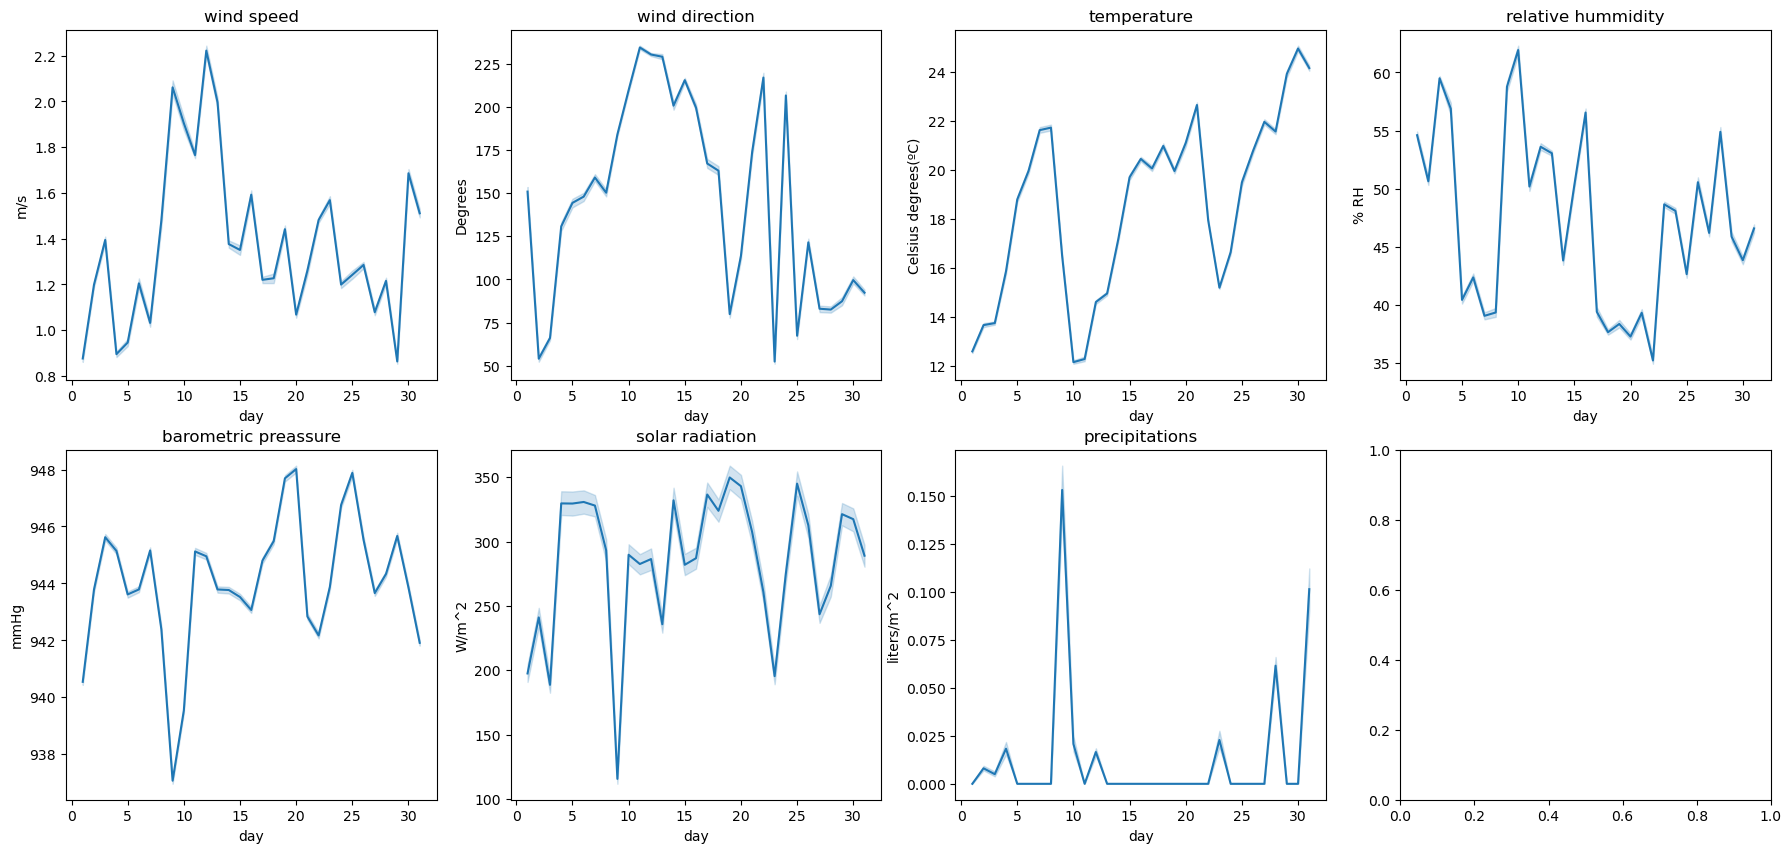

In [110]:
nrows = 2
ncols = 4

magnitude_dict = {
    81: {"name": "wind speed",
         "units": "m/s"},
    82: {"name": "wind direction",
         "units": "Degrees"},
    83: {"name": "temperature",
         "units": "Celsius degrees(ºC)"},
    86: {"name": "relative hummidity",
         "units": "% RH"},
    87: {"name": "barometric preassure",
         "units": "mmHg"},
    88: {"name": "solar radiation",
         "units": "W/m^2"},
    89: {"name": "precipitations",
         "units": "liters/m^2"},
}


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 10))


for index, magnitude in enumerate(MAGNITUDES):
    # this is to build the rows and columns of the subplot
    if index < ncols:
        row = 0
        col = index
    else:
        row = 1
        col = index - ncols

    sns.lineplot(data=hist_stations_weather, x="day", y=magnitude, ax=axes[row, col])
    
    
    # setting titles and units to the subplots
    axes[row,col].set(title=magnitude_dict.get(magnitude).get("name"), ylabel=magnitude_dict.get(magnitude).get("units"))